# Integration full regime and plots

#### Boltzmann equations for the asymmetries:

\begin{equation}
\begin{gathered}
       \frac{d Y_{\Delta\chi}}{dx} =  -\frac{s \, x}{H(1)} \Bigg[  2{\langle \sigma v \rangle _{\chi^\ast\chi^\ast\to N N}} \Big(Y_{\chi}^2-Y_{\chi^\ast}^2 - P \big(Y_{\bar{N}}^2-Y_{N}^2\big)\Big)+2{\langle \sigma v \rangle _{\chi N\to \chi^\ast\bar{N}}} \Big(Y_{\chi}Y_{N} - Y_{\chi^\ast}Y_{\bar{N}}\Big)\Bigg],\\
       \end{gathered}
\end{equation}

\begin{equation}
\begin{gathered}
       \frac{d Y_{\Delta N}}{dx} =   -\frac{s \, x}{H(1)} \Bigg[  2{\langle \sigma v \rangle _{\chi^\ast\chi^\ast\to N N}} \Big(Y_{\chi}^2-Y_{\chi^\ast}^2 - P \big(Y_{\bar{N}}^2-Y_{N}^2\big)\Big)+2{\langle \sigma v \rangle _{\chi N\to \chi^\ast\bar{N}}} \Big(Y_{\chi}Y_{N} - Y_{\chi^\ast}Y_{\bar{N}}\Big)\\
       +{\langle \sigma v \rangle _{N\bar{d}\to ud}}\Big(Y_{N} Y_{\bar{d}}^{\rm eq}-Y_{\bar{N}}Y_{d}^{\rm eq} -Y_{u}^{\rm eq}Y_{d}^{\rm eq} +Y_{\bar{u}}^{\rm eq}Y_{\bar{d}}^{\rm eq} \Big) \Bigg],
              \end{gathered}
\end{equation}

\begin{equation}
\begin{gathered}
       \frac{d \big(Y_{\Delta B}-Y_{\Delta L}\big)}{dx} =0.
              \end{gathered}
\end{equation}


#### At high temperatures they can be approximated to:


\begin{equation}
\begin{gathered}
       \frac{d Y_{\Delta\chi}}{dx} \approx  -\frac{s \, x}{H(1)}2 \frac{Y_\chi^{\rm med}}{\Lambda_2^2} \bigg( \frac{Y_{\Delta\chi}}{10}+\frac{Y_{\Delta N}}{20} \bigg),\\
       \end{gathered}
\end{equation}

\begin{equation}
\begin{gathered}
       \frac{d Y_{\Delta N}}{dx} \approx   -\frac{s \, x}{H(1)} \Bigg[ 2 \frac{Y_\chi^{\rm med}}{\Lambda_2^2} \bigg( \frac{Y_{\Delta\chi}}{10}+\frac{Y_{\Delta N}}{20} \bigg)
       +{\langle \sigma v \rangle _{N\bar{d}\to ud}}Y_q^{\rm med}\frac{1}{2}\bigg( Y_{\Delta N}-\frac{7Y_{\Delta B}}{2}\bigg) \Bigg],
              \end{gathered}
\end{equation}

\begin{equation}
\begin{gathered}
       \frac{d Y_{\Delta B}}{dx} \approx{c\,\frac{s \, x}{H(1)}\langle \sigma v \rangle _{N\bar{d}\to ud}}Y_q^{\rm med}\frac{1}{2}\bigg( Y_{\Delta N}-\frac{7Y_{\Delta B}}{2}\bigg) .
              \end{gathered}
\end{equation}


\begin{equation}
\begin{gathered}
        Y_{\Delta L} =-\frac{1-c}{c} Y_{\Delta B}.
              \end{gathered}
\end{equation}

## Imports and definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, quad, solve_ivp
from scipy.interpolate import interp1d
from IPython.display import display, Markdown
from scipy.special import kn #modified Bessel function of the second kind, order n
import time
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator,NullFormatter,LogLocator)
majorFormatter = FormatStrFormatter('%d')
from f import odeint_steps_coupled, sci_notation
import csv
from matplotlib.lines import Line2D
from multiprocessing import Process, Value
import math

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

In [2]:
path = '/home/mar/Desktop/Master Thesis/Calculations/WIMP_Boltzmann_eq_solution/dof_table'

T_MeV = np.loadtxt(path)[:,0]
g_star_s_data = np.loadtxt(path)[:,8] #For entropy 
g_star_data = np.loadtxt(path)[:,7]
T_GeV = T_MeV / 1000 #Temperature in GeV
g_star_s =  interp1d(T_GeV, g_star_s_data, bounds_error=False, fill_value='nan', kind='linear') 
g_star =  interp1d(T_GeV, g_star_data, bounds_error=False, fill_value='nan', kind='linear') 

In [3]:
gx = 1
gN = 2
Mpl = 2.435e18 #GeV
mx = 5.03489
mN = 3
c = 36/111

def s(T): #GeV
    return 2 * np.pi**2 / 45 * g_star_s(T) * T**3

def YN_eq(x): #Neglecting chemical potential!
    T = mx / x
    return 2*45 / (4*np.pi**4) * (mN/T)**2 / g_star_s(T) * kn(2, mN/T)

def Yx_eq(x): #Neglecting chemical potential!
    T = mx / x
    return 1*45 / (4*np.pi**4) * (mx/T)**2 / g_star_s(T) * kn(2, mx/T)

def P(x):
    T = mx / x
    return  (gx/gN)**2 * (mx/mN)**4 * (kn(2, mx/T)/kn(2, mN/T))**2

def lambda_(x):
    T = mx / x
    return 4*np.pi / np.sqrt(90) * mx * Mpl * np.sqrt(g_star(T))

Yq_eq = 0.00387 #Se refiere al de Yu o al de Yd, no a la suma

In [4]:
with open("Files/ThAvCrossSection_x.csv") as file:
    csvreader = csv.reader(file)
    x_table = np.array(list(csvreader)).astype(float)[0] 
    
with open("Files/ThAvCrossSection_Annihilation.csv") as file:
    csvreader = csv.reader(file)
    sigmav_ann_table = np.array(list(csvreader)).astype(float)[0]
    
with open("Files/ThAvCrossSection_Scattering.csv") as file:
    csvreader = csv.reader(file)
    sigmav_scatt_table = np.array(list(csvreader)).astype(float)[0]   /   8 #Factor 8

x_table_extended = np.append(np.append(1e-15, x_table), 1e15)
sigmav_ann_table_extended = np.append(np.append(sigmav_ann_table[0], sigmav_ann_table), sigmav_ann_table[-1])
sigmav_scatt_table_extended = np.append(np.append(sigmav_scatt_table[0], sigmav_scatt_table), sigmav_scatt_table[-1])

sigmav_ann_interp = interp1d(np.log10(x_table_extended), np.log10(sigmav_ann_table_extended), kind='linear')   
sigmav_scatt_interp = interp1d(np.log10(x_table_extended), np.log10(sigmav_scatt_table_extended), kind='linear')

def sigma_ann(T, Lambda):
    return 10**sigmav_ann_interp(np.log10(mx/T)) / Lambda**2

def sigma_scatt(T, Lambda2):
    return 10**sigmav_scatt_interp(np.log10(mx/T))/ Lambda2**2


In [5]:
def Gamma_decay(Lambda_n):
    tau_decay = 1.6 * (Lambda_n/1e5)**4 * (1/mN)**5 #s
    return 1 / tau_decay * 6.58212e-25 #GeV

def rk(x):
    xt=697.5
    if x>xt:
        ratio=kn(1,xt)/kn(2,xt)
    else:
        ratio=kn(1,x)/kn(2,x)
    return ratio

def Gamma_averaged(Lambda_n, x):
    return Gamma_decay(Lambda_n) * rk(x)

def T_decay(Lambda_n):
    return np.sqrt(Mpl*Gamma_decay(Lambda_n))

## Definition of equations:

### High temperature and DM freeze-,out

In [6]:
def eqs_xtot_Ntot_Dx_DN_DB(x, Ys): #High T and DM freeze-out
    
    Yxtot, YNtot, YDx, YDN, YDB = Ys
    
    T = mx / x
    Yxmed = Yx_eq(x)
    Yqmed = Yq_eq
    
    Lambda_0_interaction = sigma_ann(T, Lambda0) * (P(x)*(YDN**2-YNtot**2) + (Yxtot**2-YDx**2))/4
    Lambda_2_interaction_ann = sigma_ann(T, Lambda2) * (-P(x)*(YDN**2+YNtot**2) + Yxtot**2 + YDx**2)/2
    Lambda2_interactions = Yxmed / Lambda2**2 * (YDx/10 + YDN/20)
#     NeutronPortalInteractions = sigmavNP * Yqmed * (7*YDN - 2*YDB)/4
    NeutronPortalInteractions = sigmavNP * Yqmed * (36*YDN - 11*YDB)
    
    f = [-lambda_(x) / x**2 * (2* Lambda_0_interaction + 2* Lambda_2_interaction_ann),
         -lambda_(x) / x**2 * (-2* Lambda_0_interaction - 2* Lambda_2_interaction_ann + NeutronPortalInteractions),
         -lambda_(x) / x**2 *(2*Lambda2_interactions),
         -lambda_(x) / x**2 *(2*Lambda2_interactions + NeutronPortalInteractions),
          lambda_(x) / x**2 * c * NeutronPortalInteractions]

    return f

### Low temperature and decay of N:

In [7]:
def eqs_Ntot_DN_DB(x, Ys): #N decay
    
    YNtot, YDN, YDB = Ys
    
    T = mx / x

    f = [-lambda_(x) / x**2 / s(T) * Gamma_averaged(Lambda_n, x) * (YNtot - YN_eq(x) - YN_eq(x)),
         -lambda_(x) / x**2 / s(T) * Gamma_averaged(Lambda_n, x) * (YDN ),#- YN_eq(x) + YN_eq(x)),
         +lambda_(x) / x**2 / s(T) * Gamma_averaged(Lambda_n, x) * (YDN ) #- YN_eq(x) + YN_eq(x))
        ]

    return f

## Numerical integration

In [8]:
Lambda0 = 3e3
Lambda2 = 1.8e110
sigmavNP = 1e-15 #in equilibrium
Lambda_n = 8e5
# sigmavNP = 1e-50
Tin = 1e5
x_in = mx / Tin

x1 = np.logspace(np.log10(x_in), 3, 100000)
x2 = np.logspace(3, 5.4, 100000)

YDx_in = 1e-9

############################## REGIME 1

Y0s1 = [2*Yx_eq(x1[0]), 2*YN_eq(x1[0]), YDx_in, YDx_in, 0]

Ys1, fo = odeint(eqs_xtot_Ntot_Dx_DN_DB, Y0s1, x1, tfirst=True, atol=1e-20, rtol=1e-4, full_output=1)

############################## REGIME 2

Y0s2 = [Ys1[-1,1], Ys1[-1,3], Ys1[-1,4]]

Ys2, fo = odeint(eqs_Ntot_DN_DB, Y0s2, x2, tfirst=True, atol=1e-17, rtol=1e-2, full_output=1)

############################## EVERYTHING TOGETHER
x = np.append(x1, x2)
x0 = mx / np.logspace(8.2, 5, 10)
xfo = np.logspace(np.log10(x1[-1]), 8.5, 10)
xfo2 = np.logspace(np.log10(x2[-1]), 8.5, 10)

Y_xtot_interp = interp1d(np.append(np.append(x0,x1), xfo), np.append(np.append(np.ones(10)*Ys1[0,0],Ys1[:,0]), np.ones(10)*Ys1[-1,0]), bounds_error=False, fill_value='nan', kind='linear')
Y_Ntot_interp = interp1d(np.append(x0,x), np.append(np.ones(10)*Ys1[0,1],np.append(Ys1[:,1],Ys2[:,0])), bounds_error=False, fill_value='nan', kind='linear')
Y_Dx_interp = interp1d(np.append(x1, xfo), np.append(Ys1[:,2], np.ones(10)*Ys1[-1,2]), bounds_error=False, fill_value='nan', kind='linear')
Y_DN_interp = interp1d(x, np.append(Ys1[:,3], Ys2[:,1]), bounds_error=False, fill_value='nan', kind='linear')
Y_DB_interp = interp1d(np.append(x, xfo2) , np.append(np.append(Ys1[:,4], Ys2[:,2]), np.ones(10)*Ys2[-1,2]), bounds_error=False, fill_value='nan', kind='linear')
Y_DL_interp = interp1d(np.append(x1, xfo), np.append(-(1-c)/c * Ys1[:,4], np.ones(10)*-(1-c)/c * Ys1[-1,4]), bounds_error=False, fill_value='nan', kind='linear')

def Yxtot(x):
    return np.squeeze(Y_xtot_interp(x).transpose())
def YNtot(x):
    return np.squeeze(Y_Ntot_interp(x).transpose())
def YDx(x):
    return np.squeeze(Y_Dx_interp(x).transpose())
def YDN(x):
    return np.squeeze(Y_DN_interp(x).transpose())
def YDB(x):
    return np.squeeze(Y_DB_interp(x).transpose())
def YDL(x):
    return np.squeeze(Y_DL_interp(x).transpose())

## Plots:

In [9]:
def plot(Yxtot, YNtot, YDx, YDN, YDB, YDL):
    
    greeen = 0.38, 0.851, 0.443
    
    x_plot = np.logspace(np.log10(x0[0]), np.log10(xfo[-1]), 100000)
    T_plot = mx / x_plot

    fig, ax = plt.subplots(figsize=(6.67*0.65, 6.67*0.65*(0.6)), dpi=180)

#     plt.title(r'$T_{{\rm in}} = 10^5$ GeV, $\Lambda_2 = {}$ GeV, $\langle\sigma v\rangle_{{\rm NP}} = {}$ GeV$^{{-2}}$'.format(sci_notation(Lambda2, 1), sci_notation(sigmavNP)), fontsize = 10, y=1.01)
    
    plt.plot(T_plot, Yxtot(x_plot), '-.', color='mediumseagreen', linewidth=1.5, label=(r'$Y_{\chi}^{\rm tot}$'))

    plt.plot(T_plot, YDx(x_plot), linewidth=1.7, color=greeen, alpha=1, label=(r'$Y_{\Delta \chi}$'), zorder=1.8)
    
    plt.plot(T_plot, YNtot(x_plot), '-.', linewidth=1.5, color='orange', label=(r'$Y_{N}^{\rm tot}$'), zorder=2)

    plt.plot(T_plot[:], np.abs(YDN(x_plot[:])), linewidth=1.5, color='orange',label=(r'$Y_{\Delta N}$'), zorder=2)
    plt.plot(mx/x1[:4], np.abs(Ys1[:4,3]), linewidth=1.5, color='orange')

    plt.plot(T_plot, np.abs(YDB(x_plot)), '-', linewidth=1.5, color='mediumpurple', label=(r'$Y_{\Delta q}/3$'), zorder=1.1)
    plt.plot(mx/x1[:4], np.abs(Ys1[:4,4]), '-', linewidth=1.5, color='mediumslateblue', zorder=1.1)

    plt.plot(T_plot, np.abs(YDL(x_plot)), '-',linewidth=1.5,  color='cornflowerblue', alpha=0.8, label=(r'$|Y_{\Delta \ell}|$'), zorder=1)
    plt.plot(mx/x1[:4], np.abs(-(1-c)/c *Ys1[:4,4]), '-', linewidth=1.5, color='cornflowerblue', alpha=0.8, zorder=1)

    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-13,1e-1)
    plt.xlim(mx/x1[0], mx/xfo[-1])
    
    plt.tick_params(which='both', bottom=True, top=False, left=False, right=False)
    plt.tick_params(axis='both', which='major', direction='in', length = 5, labelsize=10)
    plt.tick_params(axis='both', which='minor', direction='in', length = 3, labelsize=10)
    plt.tick_params(labelleft=False, labelright=False, labeltop=False)

    ax2 = ax.twinx()
    ax2.loglog(T_plot, np.abs(YDL(x_plot)), linewidth=0)
    ax2.set_yticks([Ys2[-1,2]])
    ax2.set_yticklabels([r'$Y_{B}$'], fontsize=10)
    ax2.set_ylim(ax.get_ylim())
    
    ax.set_xticks(ticks=[1e5, mx, T_decay(Lambda_n)])
    ax.set_xticklabels([r'$T_{\rm in}$', r'$T_{\rm DM}$', r'$T_{\rm decay}$'])
    ax.tick_params(axis='y', left=False)
    
    ax.legend(loc=0, prop={'size': 9}, handlelength=1.6, frameon=False)#, bbox_to_anchor=(1, 0.85))
    
    plt.xlabel(r'$T$ [GeV]', fontsize=10)
    ax.set_ylabel(r'$Y$', fontsize=10)


In [10]:
x_plot = np.logspace(np.log10(x0[0]), np.log10(xfo[-1]), 100000)
T_plot = mx / x_plot
YDN(x_plot[1400])

array(nan)

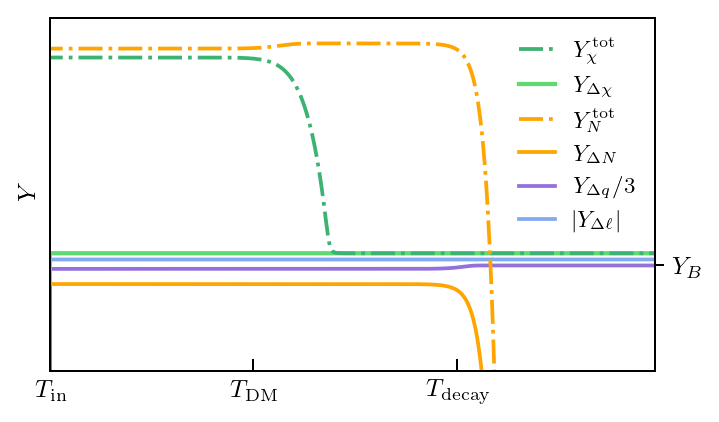

In [11]:
plot(Yxtot, YNtot, YDx, YDN, YDB, YDL)
# plt.vlines(1e2, 1e-17, 1e1)
# plt.savefig('Paper_Latex/YieldsAll_no_washout_m1_9.pdf', bbox_inches='tight', transparent=True)
#Ticks, compact, YB, reduce linelength in legend.

In [12]:
print((YDB(20000))/8.7e-11)

3.7687437232068572


In [13]:
YDN(1e-3)/YDB(1e-3)/(11/36)

0.9999999999999998

### Case without Sphalerons:

In [14]:
c=1

In [15]:
Lambda0 = 3e3
Lambda2 = 4.5e10
Lambda2 = 4.5e100
sigmavNP = 1e-15 #in equilibrium
Lambda_n = 8e5
# sigmavNP = 1e-50
Tin = 1e5
x_in = mx / Tin

x1 = np.logspace(np.log10(x_in), 3, 100000)
x2 = np.logspace(3, 5.6, 100000)

YDx_in = 1e-9

##############################

Y0s1 = [2*Yx_eq(x1[0]), 2*YN_eq(x1[0]), YDx_in, YDx_in, 0]

Ys1, fo = odeint(eqs_xtot_Ntot_Dx_DN_DB, Y0s1, x1, tfirst=True, atol=1e-20, rtol=1e-4, full_output=1)

##############################

Y0s2 = [Ys1[-1,1], Ys1[-1,3], Ys1[-1,4]]

Ys2, fo = odeint(eqs_Ntot_DN_DB, Y0s2, x2, tfirst=True, atol=1e-17, rtol=1e-2, full_output=1)
##############################
x = np.append(x1, x2)
x0 = mx / np.logspace(9, 5, 10)
xfo = np.logspace(np.log10(x1[-1]), 8, 10)
xfo2 = np.logspace(np.log10(x2[-1]), 8, 10)

Y_xtot_interp = interp1d(np.append(np.append(x0,x1), xfo), np.append(np.append(np.ones(10)*Ys1[0,0],Ys1[:,0]), np.ones(10)*Ys1[-1,0]), bounds_error=False, fill_value='nan', kind='linear')
Y_Ntot_interp = interp1d(np.append(x0,x), np.append(np.ones(10)*Ys1[0,1],np.append(Ys1[:,1],Ys2[:,0])), bounds_error=False, fill_value='nan', kind='linear')
Y_Dx_interp = interp1d(np.append(x1, xfo), np.append(Ys1[:,2], np.ones(10)*Ys1[-1,2]), bounds_error=False, fill_value='nan', kind='linear')
Y_DN_interp = interp1d(x, np.append(Ys1[:,3], Ys2[:,1]), bounds_error=False, fill_value='nan', kind='linear')
Y_DB_interp = interp1d(np.append(x, xfo2) , np.append(np.append(Ys1[:,4], Ys2[:,2]), np.ones(10)*Ys2[-1,2]), bounds_error=False, fill_value='nan', kind='linear')
Y_DL_interp = interp1d(np.append(x1, xfo), np.append(-(1-c)/c * Ys1[:,4], np.ones(10)*-(1-c)/c * Ys1[-1,4]), bounds_error=False, fill_value='nan', kind='linear')

def Yxtot(x):
    return np.squeeze(Y_xtot_interp(x).transpose())
def YNtot(x):
    return np.squeeze(Y_Ntot_interp(x).transpose())
def YDx(x):
    return np.squeeze(Y_Dx_interp(x).transpose())
def YDN(x):
    return np.squeeze(Y_DN_interp(x).transpose())
def YDB(x):
    return np.squeeze(Y_DB_interp(x).transpose())
def YDL(x):
    return np.squeeze(Y_DL_interp(x).transpose())

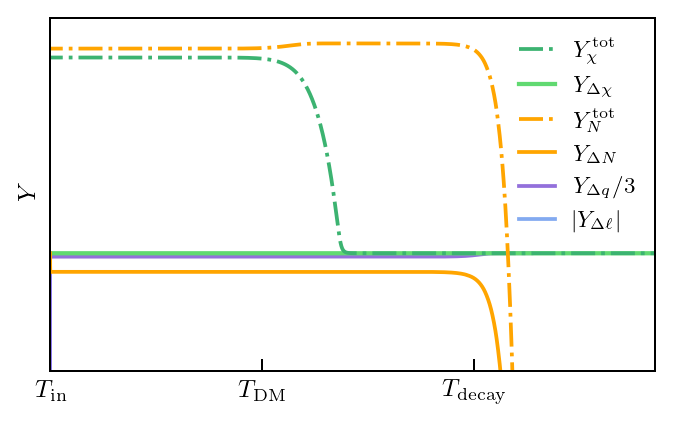

In [16]:
plot(Yxtot, YNtot, YDx, YDN, YDB, YDL)
# plt.savefig('Paper_Latex/YieldsAll_NoSph_no_washout.pdf', bbox_inches='tight', transparent=True)


In [17]:
print((YDB(20000))/8.7e-11)

9.780180968084988


### Plot for poster Japan:

In [20]:
Lambda0 = 3e3
Lambda2 = 4.5e10
# Lambda2 = 4.5e100
sigmavNP = 1e-15 #in equilibrium
Lambda_n = 8e5
# sigmavNP = 1e-50
Tin = 1e5
x_in = mx / Tin

x1 = np.logspace(np.log10(x_in), 3, 100000)
x2 = np.logspace(3, 5.6, 100000)

YDx_in = 1e-9

##############################

Y0s1 = [2*Yx_eq(x1[0]), 2*YN_eq(x1[0]), YDx_in, YDx_in, 0]

Ys1, fo = odeint(eqs_xtot_Ntot_Dx_DN_DB, Y0s1, x1, tfirst=True, atol=1e-20, rtol=1e-4, full_output=1)

##############################

Y0s2 = [Ys1[-1,1], Ys1[-1,3], Ys1[-1,4]]

Ys2, fo = odeint(eqs_Ntot_DN_DB, Y0s2, x2, tfirst=True, atol=1e-17, rtol=1e-2, full_output=1)
##############################
x = np.append(x1, x2)
x0 = mx / np.logspace(9, 5, 10)
xfo = np.logspace(np.log10(x1[-1]), 8, 10)
xfo2 = np.logspace(np.log10(x2[-1]), 8, 10)

Y_xtot_interp = interp1d(np.append(np.append(x0,x1), xfo), np.append(np.append(np.ones(10)*Ys1[0,0],Ys1[:,0]), np.ones(10)*Ys1[-1,0]), bounds_error=False, fill_value='nan', kind='linear')
Y_Ntot_interp = interp1d(np.append(x0,x), np.append(np.ones(10)*Ys1[0,1],np.append(Ys1[:,1],Ys2[:,0])), bounds_error=False, fill_value='nan', kind='linear')
Y_Dx_interp = interp1d(np.append(x1, xfo), np.append(Ys1[:,2], np.ones(10)*Ys1[-1,2]), bounds_error=False, fill_value='nan', kind='linear')
Y_DN_interp = interp1d(x, np.append(Ys1[:,3], Ys2[:,1]), bounds_error=False, fill_value='nan', kind='linear')
Y_DB_interp = interp1d(np.append(x, xfo2) , np.append(np.append(Ys1[:,4], Ys2[:,2]), np.ones(10)*Ys2[-1,2]), bounds_error=False, fill_value='nan', kind='linear')
Y_DL_interp = interp1d(np.append(x1, xfo), np.append(-(1-c)/c * Ys1[:,4], np.ones(10)*-(1-c)/c * Ys1[-1,4]), bounds_error=False, fill_value='nan', kind='linear')

def Yxtot(x):
    return np.squeeze(Y_xtot_interp(x).transpose())
def YNtot(x):
    return np.squeeze(Y_Ntot_interp(x).transpose())
def YDx(x):
    return np.squeeze(Y_Dx_interp(x).transpose())
def YDN(x):
    return np.squeeze(Y_DN_interp(x).transpose())
def YDB(x):
    return np.squeeze(Y_DB_interp(x).transpose())
def YDL(x):
    return np.squeeze(Y_DL_interp(x).transpose())

In [21]:
def plot_poster(Yxtot, YNtot, YDx, YDN, YDB, YDL):
    
    greeen = 0.439, 0.659, 0.467
    greeen2 = 0.180, 0.862, 0.352
    rosa = 0.862, 0.180, 0.647
    asul = 0.301, 0.396, 0.858
    asulCloaro = 0.435, 0.513, 0.886
    x_plot = np.logspace(np.log10(x0[0]), np.log10(xfo[-1]), 100000)
    T_plot = mx / x_plot

    fig, ax = plt.subplots(figsize=(6.67*0.65, 6.67*0.65*(0.5)), dpi=180)

#     plt.title(r'$T_{{\rm in}} = 10^5$ GeV, $\Lambda_2 = {}$ GeV, $\langle\sigma v\rangle_{{\rm NP}} = {}$ GeV$^{{-2}}$'.format(sci_notation(Lambda2, 1), sci_notation(sigmavNP)), fontsize = 10, y=1.01)
    
    plt.plot(T_plot, Yxtot(x_plot), '-.', color=asul, linewidth=1.5, label=(r'$Y_{\chi}^{\rm tot}$'))

    plt.plot(T_plot, YDx(x_plot), linewidth=1.7, color=asulCloaro, alpha=1, label=(r'$Y_{\Delta \chi}$'), zorder=1.8)
    
    plt.plot(T_plot, YNtot(x_plot), '-.', linewidth=1.5, color=greeen2, label=(r'$Y_{N}^{\rm tot}$'), zorder=2)

    plt.plot(T_plot[:], np.abs(YDN(x_plot[:])), linewidth=1.5, color=greeen2, label=(r'$Y_{\Delta N}$'), zorder=2)
    plt.plot(mx/x1[:4], np.abs(Ys1[:4,3]), linewidth=1.5, color=greeen2)

    plt.plot(T_plot, np.abs(YDB(x_plot)), '-', linewidth=1.5, color='orange', label=(r'$Y_{\Delta q}/3$'), zorder=2.1)
    plt.plot(mx/x1[:4], np.abs(Ys1[:4,4]), '-', linewidth=1.5, color='orange', zorder=2.1)
    plt.plot([T_plot[-20000],T_plot[-1]], np.ones(2)*Ys2[-20000,2], '-', linewidth=1.5, color='orange', zorder=2.1)

#     plt.plot(T_plot, np.abs(YDL(x_plot)), '-',linewidth=1.5,  color='cornflowerblue', alpha=0.8, label=(r'$|Y_{\Delta \ell}|$'), zorder=1)
#     plt.plot(mx/x1[:4], np.abs(-(1-c)/c *Ys1[:4,4]), '-', linewidth=1.5, color='cornflowerblue', alpha=0.8, zorder=1)

    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-13,1e-1)
    plt.xlim(mx/x1[0], mx/xfo[-1])
    
    plt.tick_params(which='both', bottom=True, top=False, left=False, right=False)
    plt.tick_params(axis='both', which='major', direction='in', length = 5, labelsize=10)
    plt.tick_params(axis='both', which='minor', direction='in', length = 3, labelsize=10)
    plt.tick_params(labelleft=False, labelright=False, labeltop=False)

    ax2 = ax.twinx()
    ax2.loglog(T_plot, np.abs(YDL(x_plot)), linewidth=0)
    ax2.set_yticks([Ys2[-10000,2]])
    ax2.set_yticklabels([r'$Y_{B}$'], fontsize=10)
    ax2.set_ylim(ax.get_ylim())
    
    ax.set_xticks(ticks=[Tin, mx, T_decay(Lambda_n)])
    ax.set_xticklabels([r'$T_{\rm in}$', r'$T_{\rm DM}$', r'$T_{\rm decay}$'])
    ax.tick_params(axis='y', left=False)
    
    ax.legend(loc=0, prop={'size': 9}, handlelength=1.6, frameon=False)#, bbox_to_anchor=(1, 0.85))
    
    plt.xlabel(r'$T$ [GeV]', fontsize=9)
    ax.set_ylabel(r'$Y$', fontsize=9)


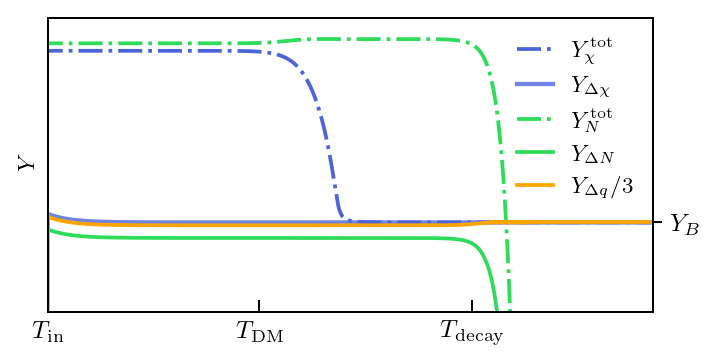

In [24]:
plot_poster(Yxtot, YNtot, YDx, YDN, YDB, YDL)
# plt.savefig('Plots/Poster_YieldsAll_NoSph.pdf', bbox_inches='tight', transparent=True)

### Plot for DM seminar:

In [25]:
c = 36/111

In [26]:
Lambda0 = 3e3
Lambda2 = 4.5e100
# Lambda2 = 4.5e100
sigmavNP = 1e-15 #in equilibrium
Lambda_n = 8e5
# sigmavNP = 1e-50
Tin = 1e5
x_in = mx / Tin

x1 = np.logspace(np.log10(x_in), 3, 100000)
x2 = np.logspace(3, 5.6, 100000)

YDx_in = 5e-10

##############################

Y0s1 = [2*Yx_eq(x1[0]), 2*YN_eq(x1[0]), YDx_in, YDx_in, 0]

Ys1, fo = odeint(eqs_xtot_Ntot_Dx_DN_DB, Y0s1, x1, tfirst=True, atol=1e-20, rtol=1e-4, full_output=1)

##############################

Y0s2 = [Ys1[-1,1], Ys1[-1,3], Ys1[-1,4]]

Ys2, fo = odeint(eqs_Ntot_DN_DB, Y0s2, x2, tfirst=True, atol=1e-17, rtol=1e-2, full_output=1)
##############################
x = np.append(x1, x2)
x0 = mx / np.logspace(9, 5, 10)
xfo = np.logspace(np.log10(x1[-1]), 8, 10)
xfo2 = np.logspace(np.log10(x2[-1]), 8, 10)

Y_xtot_interp = interp1d(np.append(np.append(x0,x1), xfo), np.append(np.append(np.ones(10)*Ys1[0,0],Ys1[:,0]), np.ones(10)*Ys1[-1,0]), bounds_error=False, fill_value='nan', kind='linear')
Y_Ntot_interp = interp1d(np.append(x0,x), np.append(np.ones(10)*Ys1[0,1],np.append(Ys1[:,1],Ys2[:,0])), bounds_error=False, fill_value='nan', kind='linear')
Y_Dx_interp = interp1d(np.append(x1, xfo), np.append(Ys1[:,2], np.ones(10)*Ys1[-1,2]), bounds_error=False, fill_value='nan', kind='linear')
Y_DN_interp = interp1d(x, np.append(Ys1[:,3], Ys2[:,1]), bounds_error=False, fill_value='nan', kind='linear')
Y_DB_interp = interp1d(np.append(x, xfo2) , np.append(np.append(Ys1[:,4], Ys2[:,2]), np.ones(10)*Ys2[-1,2]), bounds_error=False, fill_value='nan', kind='linear')
Y_DL_interp = interp1d(np.append(x1, xfo), np.append(-(1-c)/c * Ys1[:,4], np.ones(10)*-(1-c)/c * Ys1[-1,4]), bounds_error=False, fill_value='nan', kind='linear')

def Yxtot(x):
    return np.squeeze(Y_xtot_interp(x).transpose())
def YNtot(x):
    return np.squeeze(Y_Ntot_interp(x).transpose())
def YDx(x):
    return np.squeeze(Y_Dx_interp(x).transpose())
def YDN(x):
    return np.squeeze(Y_DN_interp(x).transpose())
def YDB(x):
    return np.squeeze(Y_DB_interp(x).transpose())
def YDL(x):
    return np.squeeze(Y_DL_interp(x).transpose())

In [27]:
def plot_seminar(Yxtot, YNtot, YDx, YDN, YDB, YDL):
    
    greeen = 0.439, 0.659, 0.467
    greeen2 = 0.180, 0.862, 0.352
    rosa = 0.862, 0.180, 0.647
    asul = 0.301, 0.396, 0.858
    asulCloaro = 0.435, 0.513, 0.886
    x_plot = np.logspace(np.log10(x0[0]), np.log10(xfo[-1]), 100000)
    T_plot = mx / x_plot

    fig, ax = plt.subplots(figsize=(6.67*0.65, 6.67*0.65*(0.5)), dpi=180)

#     plt.title(r'$T_{{\rm in}} = 10^5$ GeV, $\Lambda_2 = {}$ GeV, $\langle\sigma v\rangle_{{\rm NP}} = {}$ GeV$^{{-2}}$'.format(sci_notation(Lambda2, 1), sci_notation(sigmavNP)), fontsize = 10, y=1.01)
    
    plt.plot(T_plot, Yxtot(x_plot), '-.', color=asul, linewidth=1.5, label=(r'$Y_{\chi}^{\rm tot}$'))

    plt.plot(T_plot, YDx(x_plot), linewidth=1.7, color=asulCloaro, alpha=1, label=(r'$Y_{\Delta \chi}$'), zorder=1.8)
    
    plt.plot(T_plot, YNtot(x_plot), '-.', linewidth=1.5, color=greeen2, label=(r'$Y_{N}^{\rm tot}$'), zorder=0.52)

    plt.plot(T_plot[:], np.abs(YDN(x_plot[:])), linewidth=1.5, color=greeen2, label=(r'$Y_{\Delta N}$'), zorder=2)
    plt.plot(mx/x1[:4], np.abs(Ys1[:4,3]), linewidth=1.5, color=greeen2)

    plt.plot(T_plot, np.abs(YDB(x_plot)), '-', linewidth=1.5, color='red', label=(r'$Y_{\Delta q}/3$'), zorder=2.1)
    plt.plot(mx/x1[:4], np.abs(Ys1[:4,4]), '-', linewidth=1.5, color='red', zorder=2.1)
    plt.plot([T_plot[-20000],T_plot[-1]], np.ones(2)*Ys2[-20000,2], '-', linewidth=1.5, color='red', zorder=2.1)
    
    
    plt.plot(T_plot, np.abs(YDL(x_plot)), '-',linewidth=1.5,  color='orange', alpha=0.8, label=(r'$|Y_{\Delta \ell}|$'), zorder=1)
#     plt.plot(mx/x1[:4], np.abs(-(1-c)/c *Ys1[:4,4]), '-', linewidth=1.5, color='r', alpha=0.8, zorder=1)

    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-13,1e-1)
    plt.xlim(mx/x1[0], mx/xfo[-1])
    
    plt.tick_params(which='both', bottom=True, top=False, left=False, right=False)
    plt.tick_params(axis='both', which='major', direction='in', length = 5, labelsize=10)
    plt.tick_params(axis='both', which='minor', direction='in', length = 3, labelsize=10)
    plt.tick_params(labelleft=False, labelright=False, labeltop=False)

    ax2 = ax.twinx()
    ax2.loglog(T_plot, np.abs(YDL(x_plot)), linewidth=0)
    ax2.set_yticks([Ys2[-10000,2]])
    ax2.set_yticklabels([r'$Y_{B}$'], fontsize=10)
    ax2.set_ylim(ax.get_ylim())
    
    ax.set_xticks(ticks=[Tin, mx, T_decay(Lambda_n)])
    ax.set_xticklabels([r'$T_{\rm in}$', r'$T_{\rm DM}$', r'$T_{\rm decay}$'])
    ax.tick_params(axis='y', left=False)
    
    ax.legend(loc=0, prop={'size': 8}, handlelength=1.6, frameon=False)#, bbox_to_anchor=(1, 0.85))
    
    plt.xlabel(r'$T$ [GeV]', fontsize=9)
    ax.set_ylabel(r'$Y$', fontsize=9)


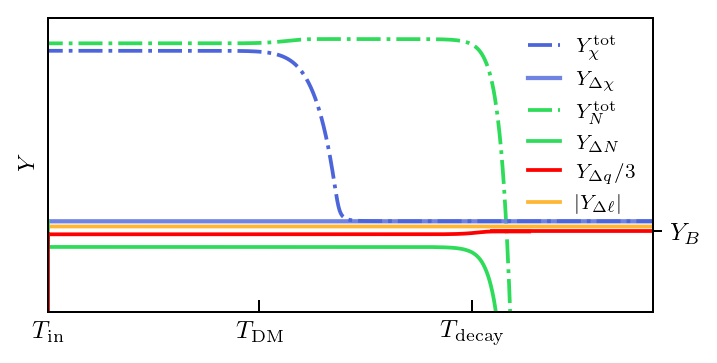

In [28]:
plot_seminar(Yxtot, YNtot, YDx, YDN, YDB, YDL)
# plt.savefig('Presentations/DM_meeting/Yields_correct_no_wo.pdf', bbox_inches='tight', transparent=True)

### Plot for thesis

In [31]:
def plot_thesis(Yxtot, YNtot, YDx, YDN, YDB, YDL):
    
    greeen = 0.439, 0.659, 0.467
    greeen2 = 0.180, 0.862, 0.352
    rosa = 0.862, 0.180, 0.647
    asul = 0.301, 0.396, 0.858
    asulCloaro = 0.435, 0.513, 0.886
    x_plot = np.logspace(np.log10(x0[0]), np.log10(xfo[-1]), 100000)
    T_plot = mx / x_plot

    fig, ax = plt.subplots(figsize=(5.5, 5.5*(0.5)), dpi=150)

#     plt.title(r'$T_{{\rm in}} = 10^5$ GeV, $\Lambda_2 = {}$ GeV, $\langle\sigma v\rangle_{{\rm NP}} = {}$ GeV$^{{-2}}$'.format(sci_notation(Lambda2, 1), sci_notation(sigmavNP)), fontsize = 10, y=1.01)
    
    plt.plot(T_plot, Yxtot(x_plot), '-.', color=asul, linewidth=2, label=(r'$Y_{\chi}^{\rm tot}$'))

    plt.plot(T_plot, YDx(x_plot), linewidth=2.2, color=asulCloaro, alpha=1, label=(r'$Y_{\Delta \chi}$'), zorder=1.8)
    
    plt.plot(T_plot, YNtot(x_plot), '-.', linewidth=2, color=greeen2, label=(r'$Y_{N}^{\rm tot}$'), zorder=0.52)

    plt.plot(T_plot[:], np.abs(YDN(x_plot[:])), linewidth=2, color=greeen2, label=(r'$Y_{\Delta N}$'), zorder=2)
    plt.plot(mx/x1[:4], np.abs(Ys1[:4,3]), linewidth=2, color=greeen2)

    plt.plot(T_plot, np.abs(YDB(x_plot)), '-', linewidth=2, color='red', label=(r'$Y_{\Delta q}/3$'), zorder=2.1)
    plt.plot(mx/x1[:4], np.abs(Ys1[:4,4]), '-', linewidth=2, color='red', zorder=2.1)
    plt.plot([T_plot[-20000],T_plot[-1]], np.ones(2)*Ys2[-20000,2], '-', linewidth=2, color='red', zorder=2.1)
    
    
    plt.plot(T_plot, np.abs(YDL(x_plot)), '-',linewidth=2,  color='orange', alpha=0.8, label=(r'$|Y_{\Delta \ell}|$'), zorder=1)
#     plt.plot(mx/x1[:4], np.abs(-(1-c)/c *Ys1[:4,4]), '-', linewidth=1.5, color='r', alpha=0.8, zorder=1)

    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-13,1e-1)
    plt.xlim(mx/x1[0], mx/xfo[-1])
    
    plt.tick_params(which='both', bottom=True, top=False, left=False, right=False)
    plt.tick_params(axis='both', which='major', direction='in', length = 5, labelsize=10)
    plt.tick_params(axis='both', which='minor', direction='in', length = 3, labelsize=10)
    plt.tick_params(labelleft=False, labelright=False, labeltop=False)

    ax2 = ax.twinx()
    ax2.loglog(T_plot, np.abs(YDL(x_plot)), linewidth=0)
    ax2.set_yticks([Ys2[-10000,2]])
    ax2.set_yticklabels([r'$Y_{B_{\rm SM}}$'], fontsize=10)
    ax2.set_ylim(ax.get_ylim())
#     ax2.tick_params(axis='y', which='major', direction='out', color='black', labelsize=10)

    ax.set_xticks(ticks=[Tin, mx, T_decay(Lambda_n)])
    ax.set_xticklabels([r'$T_{\rm in}$', r'$T_{\rm DM}$', r'$T_{\rm decay}$'])
    ax.tick_params(axis='y', left=False)
    
    ax.legend(loc=0, prop={'size': 10}, handlelength=2.2, frameon=False)#, bbox_to_anchor=(1, 0.85))
    
    plt.xlabel(r'$T$ [GeV]', fontsize=10)
    ax.set_ylabel(r'$Y$', fontsize=10)


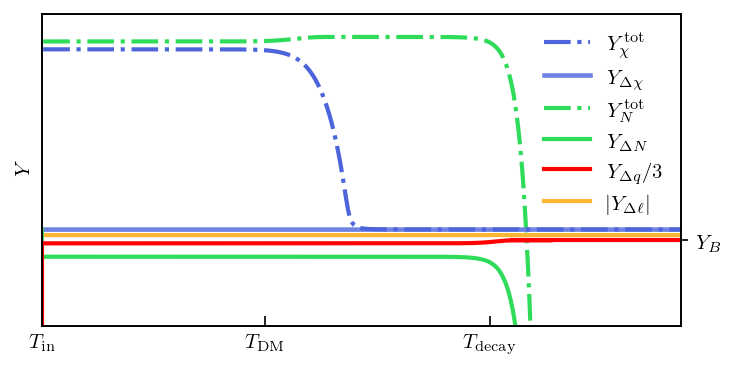

In [32]:
plot_thesis(Yxtot, YNtot, YDx, YDN, YDB, YDL)
# plt.savefig('/home/mar/Dropbox/Thesis/Figures/YieldsAll.pdf', bbox_inches='tight', transparent=True)